**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from types import SimpleNamespace
from scipy import optimize
from scipy import interpolate
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# We define symbols
alpha =sm.symbols('alpha')
kappa =sm.symbols('kappa')
nu =sm.symbols('nu')
w_hat =sm.symbols('w_hat')
L=sm.symbols('L')
G=sm.symbols('G')
W_vec=sm.symbols('W_vec')


# We define some parameter values
tau = 0.3
w = 1

# We define the consumption function
C = kappa+w_hat*L

# We define the utility function
V = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2

# At first we differentiate the utility function with respect to L and put this expression equal to zero
L_diff = sm.diff(V,L)
L_diff_eq = sm.Eq(L_diff,0)

# We solve the equation for L and display the solution
L_solve=sm.solve(L_diff_eq,L)[1]
print('The optimal labor supply choice is:')
display(L_solve)

# Since the expression we get is a bit more complicated than the one we got in the paper, we will try to make it clear that it is the same expression by plugging in the baseline parameter values
L_solve_num = sm.lambdify(args=(alpha,kappa,nu,w_hat),expr=L_solve)
L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w)

# We also plug in the parameter values in the expression we got in the paper
L_test = (-1+(1**2+4*0.5/(1/(2*16**2))*((1-0.3)*1)**2)**0.5)/(2*(1-0.3)*1)
print('The numerically optimal labor supply choice is in the exam paper:')
print(L_test)
print('The numerically optimal labor supply choice analytically is:')
print(L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w))

The optimal labor supply choice is:


(-kappa*nu + sqrt(nu*(4*alpha*w_hat**2 + kappa**2*nu)))/(2*nu*w_hat)

The numerically optimal labor supply choice is in the exam paper:
15.30165022719559
The numerically optimal labor supply choice analytically is:
15.30165022719559


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1/2)*(-kappa*nu + sqrt(nu*(4*alpha*w_hat**2 + kappa**2*nu)))/(nu*w_hat)


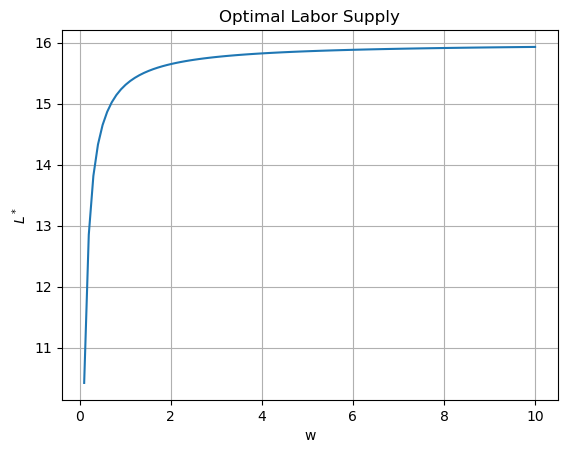

In [3]:
#Define the range of w values
w_values = np.linspace(0, 10, 100)  # Adjust the range and number of points as needed

#Create an empty list to store the optimal labor supply choices
L_optimal_values = []

#Calculate the optimal labor supply choice for each w value
for w_value in w_values:
    L_optimal = L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w_value)
    L_optimal_values.append(L_optimal)

#Plot the relationship between L* and w
plt.plot(w_values, L_optimal_values)
plt.xlabel('w')
plt.ylabel('$L^*$')
plt.title('Optimal Labor Supply')
plt.grid(True)
plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


/var/folders/qn/m3hbpy256cs_8mfcpffzgvzr0000gn/T/ipykernel_28600/39003651.py:20: RuntimeWarning: divide by zero encountered in log
  utility = np.log((1+(1-tau)*w*L)**0.5*G**0.5)-(1/(2*16**2))*L**2/2


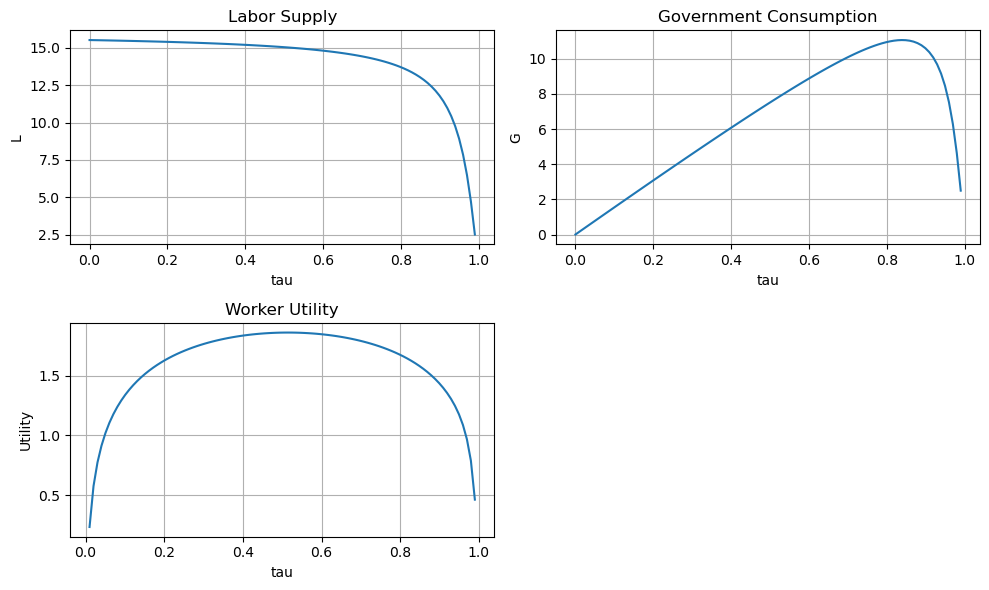

In [5]:
# Define the grid of tau-values
tau_values = np.linspace(0, 1, 100)  # Adjust the range and number of points as needed

# Create empty lists to store the values of L, G, and worker utility
L_values = []
G_values = []
utility_values = []

# Calculate the values of L, G, and worker utility for each tau-value
for tau in tau_values:
    # Calculate L
    L = L_solve_num(0.5, 1, 1/(2*16**2), (1-tau) * w)
    L_values.append(L)

    # Calculate G
    G = tau * w * L
    G_values.append(G)

    # Calculate worker utility
    utility = np.log((1+(1-tau)*w*L)**0.5*G**0.5)-(1/(2*16**2))*L**2/2
    utility_values.append(utility)

# Plot the values of L, G, and worker utility against tau
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(tau_values, L_values)
plt.xlabel('tau')
plt.ylabel('L')
plt.title('Labor Supply')
plt. grid(True)

plt.subplot(2, 2, 2)
plt.plot(tau_values, G_values)
plt.xlabel('tau')
plt.ylabel('G')
plt.title('Government Consumption')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(tau_values, utility_values)
plt.xlabel('tau')
plt.ylabel('Utility')
plt.title('Worker Utility')
plt.grid(True)

plt.tight_layout()
plt.show()


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [6]:
# write your code here

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:
# write your code here

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [8]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [9]:
# First we define the parameters of the model using sympy
l_t = sm.symbols('l_t')
y_t = sm.symbols('y_t')
w = sm.symbols('omega')
p_t = sm.symbols('p_t')
k_t = sm.symbols('kappa_t')
k = sm.symbols('kappa')
eta = sm.symbols('eta')
Pi_t = sm.symbols('Pi_t')

# Next we define the production function, the price demand function, and the profit function
y_t = l_t
p_t = k_t * y_t**-eta
Pi_t = p_t * y_t - w * l_t

# Now we find the first-order condition of the profit function with respect to labor
FOC_l = sm.solve(sm.diff(Pi_t, l_t), l_t)[0]
print('The first-order condition with respect to labor is:')
print(FOC_l)

# Now we want to define the profit function as a Python function
def profit_func(l_val, kappa_val, eta_val, w_val):
    return kappa_val * l_val**(1 - eta_val) - w_val * l_val

# next we define a function for the negative of the profit function in order to minimize it
def neg_profit_func(l_val, kappa_val, eta_val, w_val):
    return -profit_func(l_val, kappa_val, eta_val, w_val)

# We set the baseline parameter values
eta_val = 0.5
w_val = 1.0

# We set the values of kappa_t to evaluate
kappa_values = [1.0, 2.0]

# Create a loop that finds the optimal l_t and maximum profit for each value of kappa_t
for kappa_val in kappa_values:
    # Set the bounds for the optimization problem
    bounds = (0, 100)  # l_t >= 0

    # Find the value of l_t that maximizes profits
    result = optimize.minimize_scalar(neg_profit_func, bounds=bounds, args=(kappa_val, eta_val, w_val), method='bounded')

    # Retrieve the optimal l_t and maximum profit
    optimal_l_t = result.x
    max_profit = -result.fun

    print(f"Kappa = {kappa_val:.1f}: Optimal l_t = {optimal_l_t:.3f}, Maximum Profit = {max_profit:.3f}")


The first-order condition with respect to labor is:
(kappa_t*(1 - eta)/omega)**(1/eta)
Kappa = 1.0: Optimal l_t = 0.250, Maximum Profit = 0.250
Kappa = 2.0: Optimal l_t = 1.000, Maximum Profit = 1.000


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [10]:
# Set the baseline parameter values
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)

# Define the policy function
def policy_function(kappa_t, eta_val, w_val):
    return ((1 - eta_val) * kappa_t / w_val) ** (1 / eta_val)

# Define the ex-post value function
def ex_post_value(kappa_values, eta_val, w_val, rng):
    l_tm1 = 0  # Initial labor input
    h_values = []

    for kappa_t in kappa_values:
        eps_values = rng.normal(-0.5 * sigma_eps ** 2, sigma_eps, size=120)  # Generate shock series
        l_values = policy_function(kappa_t, eta_val, w_val)  # Calculate labor input based on policy function
        h_t = sum(R ** -(t+1) * (kappa_t * l_t ** (1 - eta_val) - w_val * l_t - (l_t != l_tm1) * iota) for t, (kappa_t, l_t, l_tm1) in enumerate(zip(kappa_values[1:], l_values[1:], l_values[:-1])))  # Calculate ex-post value for each period starting from t=1
        h_values.append(h_t)

    return np.mean(h_values)  # Calculate the average ex-post value

# Set the number of shock series to simulate
K = 1000  # Adjust this value if needed to ensure a good approximation

# Simulate K random shock series and calculate the expected ex-post value
rng = np.random.default_rng()
kappa_values = rng.normal(0, sigma_eps, size=(K, 120))  # Generate K shock series
H = ex_post_value(kappa_values, eta_val, w_val, rng)

print(f"The ex ante expected value of the salon is, H = {H:.4f}")


The ex ante expected value of the salon is, H = -1.4105


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [11]:
# Set the baseline parameter values
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)

# Define the policy function
def policy_function(kappa_t, eta_val, w_val, delta_val, l_tm1):
    ell_ast = ((1 - eta_val) * kappa_t / w_val) ** (1 / eta_val)
    if abs(l_tm1 - ell_ast) > delta_val:
        return ell_ast
    else:
        return l_tm1

# Define the ex-post value function
def ex_post_value(kappa_values, eta_val, w_val, delta_val, rng):
    l_tm1 = 0  # Initial labor input
    h_values = []

    for kappa_t in kappa_values:
        eps_values = rng.normal(-0.5 * sigma_eps ** 2, sigma_eps, size=120)  # Generate shock series
        l_values = [policy_function(kappa_t[t], eta_val, w_val, delta_val, l_tm1) for t in range(120)]  # Calculate labor input based on policy function
        l_values = np.array(l_values)  # Convert l_values to a NumPy array
        h_t = sum(R ** -t * (kappa_t[t] * l_values[t] ** (1 - eta_val) - w_val * l_values[t] - (l_values[t] != l_values[t-1]) * iota) for t in range(120))  # Calculate ex-post value for each period
        h_values.append(h_t)

    return np.mean(h_values)  # Calculate the average ex-post value

# Set the number of shock series to simulate
K = 1000

# Set the value of delta
delta_val = 0.05

# Simulate K random shock series and calculate the expected ex-post value
rng = np.random.default_rng()
kappa_values = rng.normal(0, sigma_eps, size=(K, 120))  # Generate K shock series
H = ex_post_value(kappa_values, eta_val, w_val, delta_val, rng)

print(f"H = {H:.4f}")


H = 0.0000


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

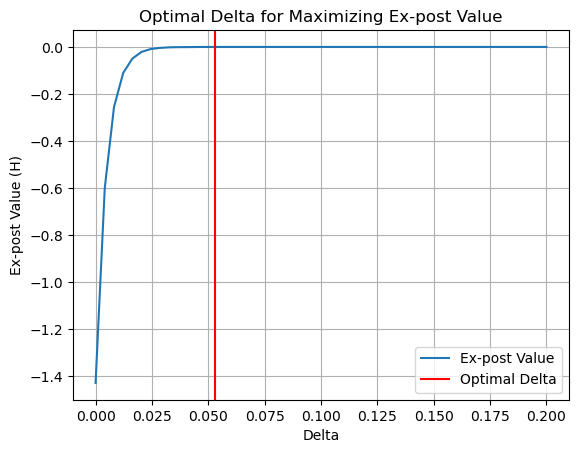

Optimal Delta = 0.0531, Maximum Ex-post Value (H) = 0.0000


In [12]:
# Set the range of delta values to evaluate
delta_values = np.linspace(0, 0.2, 50)

# Calculate H for each delta value
H_values = []
for delta_val in delta_values:
    H = ex_post_value(kappa_values, eta_val, w_val, delta_val, rng)
    H_values.append(H)

# Find the optimal delta that maximizes H
optimal_delta = delta_values[np.argmax(H_values)]
max_H = np.max(H_values)

# Plot the results
plt.plot(delta_values, H_values, label='Ex-post Value')
plt.xlabel("Delta")
plt.ylabel("Ex-post Value (H)")
plt.title("Optimal Delta for Maximizing Ex-post Value")
plt.axvline(x=optimal_delta, color='r', linestyle='-', label='Optimal Delta')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Delta = {optimal_delta:.4f}, Maximum Ex-post Value (H) = {max_H:.4f}")



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [13]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [14]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [15]:
def global_optimizer(obj_func, tau, K_warmup, K_max):

    #Define x_star at the start to be 0
    x_star = 0

    #Define the settings bounds for x1 and x2 
    bounds = np.array([[-600, 600], [-600, 600]])

    #Define a loop, where k goes from 0 to 499
    for k in range(K_max):

        #Step A: x_k (x1, x2) are drawn random uniformly within the given bounds [-600, 600]
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])

        #Step B, C, D & E: 
        if k < K_warmup: #If k is lower than 
            x_k0 = x_k
        else:
            chi_k = 0.5 * (2 / (1 + np.exp((k - K_warmup) / 100)))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star

        result = optimize.minimize(obj_func, x_k0, method='BFGS', tol=tau)

        if k == 0 or result.fun < obj_func(x_star):
            x_star = result.x

        if result.fun < tau:
            break
                
    return x_star


#Define rest of the settings
tau = 1e-8
K_warmup = 10
K_max = 1000 

# Call the global optimizer function
best_solution = global_optimizer(griewank, tau, K_warmup, K_max)

print("x_1 is:", best_solution[0])
print("x_1 is:", best_solution[1])
print("Best Value:", griewank(best_solution))
print(f'steady state in the FF system = {ss_k_FF:.3f}')

x_1 is: -8.161146829605313e-09
x_1 is: -1.3644760729610375e-08
Best Value: 0.0


NameError: name 'ss_k_FF' is not defined

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?